In [231]:
import glob
import pandas as pd
from array import ArrayType
import numpy as np

# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
saveFolderName = "peak"
genSavePath = f"{os.getcwd()}/SavedResults/"

In [232]:
import paradigmSetting
day = "01" # Which month and days result you want to visualize in table
month = 12
# paradigm = paradigmSetting.upDownRightLeftVis()
#paradigm = paradigmSetting.rightLeftVis()
paradigm = paradigmSetting.upDownVis()
nrOfLabels = 2

paraName = paradigm[0]
cmbSize = 3
repetitionValue = 46
featureSelect = "OnlySepOnlyCurr01th"

labels = np.arange(nrOfLabels)
saveTop = True


In [233]:
repetitionName = f"{paraName}{cmbSize}c{featureSelect}" #"debuggingOnlyCurrthreeAv2correct" #"debuggingOnlyPreNotCurrthreeAv2Correct"# "testAvgDoubleBC4labelsinner2c" # "testAvgDoubleBC4labels1c" # #"peak4-const3-i-ud-global-10-3c"  # "i-ud-global-05-2c" # # "withFixedButWorse3"# #  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")
if saveTop:
    saveTopName = f"top{cmbSize}{paraName}.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.0
print(len(savedResults))
print(len(savedResults)/9)

90
10.0


In [234]:
def getRes(combinationResult, combinationResultSep, allCombinations, featCombos, label, nrOfCombination, labels): 
    headers = np.arange(nrOfCombination)
    subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
    subjectNrList = []  
    comboAverage = np.zeros([1, nrOfCombination])
    comboTotal = np.zeros([1, nrOfCombination])
    nrOfSubjects = np.zeros(nrOfCombination)
    combResLabel = labels[-1] + 1
    print(labels)
    print(combResLabel)
    print(label)
    topTen = []
    topCombResTen = []
    topThreeAllSubjects = []
    topCombResThreeAllSubjects = []
    topPerFeature = np.zeros([10, len(featCombos)])
    topCombResPerFeature = np.zeros([10, len(featCombos)])
    allCombinations = np.array(allCombinations)
    lowestTopRes = [0, 0]
    for subNr, (cResult, sepResult) in enumerate(zip(combinationResult, combinationResultSep)):
        topThreeThisSubject = []
        topCombResThreeThisSubject = []
        resArray = np.zeros([nrOfCombination])
        if len(cResult) != 0:
            for res, sres in zip(cResult,sepResult):
                cmbNr = int(res[0])
                if onlySignificant == True:
                    if res[1] < minAcc:
                        continue
                res[1] = sres[label+1]
                # print(sres)
                combRes = sres[combResLabel+1]
                # print(combResLabel)
                # print(combResLabel+1)
                comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
                comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
                nrOfSubjects[cmbNr] += 1
                subjectResultArray[subNr, cmbNr] = res[1]
                comboName = allCombinations[cmbNr][0]
                nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
                if combRes > topCombResPerFeature[subNr, nameIndex]:
                    topPerFeature[subNr, nameIndex] = res[1]
                    topCombResPerFeature[subNr, nameIndex] = combRes
                    
                if len(topCombResTen) < 10 or topCombResTen[-1][0] < combRes:

                    if len(topTen) == 10:
                        # topTen.reverse()
                        topTen.pop()
                    if len(topCombResTen) == 10:
                        # topTen.reverse()
                        topCombResTen.pop()

                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topTen.append([res[1], subNr, dataF, kernel, cVal])
                    topCombResTen.append([combRes, subNr, dataF, kernel, cVal])
                    topTen.sort(reverse=True)
                    topCombResTen.sort(reverse=True)
                    
                # if len(topCombResThreeThisSubject) > 1:
                #     # print(topCombResThreeThisSubject[0][0])
                #     # print("heyNoni")
                #     # print(topCombResThreeThisSubject[1][0])
                 
                if len(topCombResThreeThisSubject) < 2 or topCombResThreeThisSubject[-1][0] < combRes:
                    
                    
                    if len(topThreeThisSubject) == 2:
                        # topThreeThisSubject.reverse()
                        topThreeThisSubject.pop()
                    if len(topCombResThreeThisSubject) == 2:
                        # print(f"PrePop{topCombResThreeThisSubject}")
                        #topCombResThreeThisSubject.reverse()
                        topCombResThreeThisSubject.pop()
                        # print(f"PostPop{topCombResThreeThisSubject}")
                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                    topThreeThisSubject.sort(reverse=True)
                    topCombResThreeThisSubject.append([combRes, subNr, dataF, kernel, cVal])
                    # print(f"PreSort{topCombResThreeThisSubject}")
                    topCombResThreeThisSubject.sort(reverse=True)
                    # print(f"PostSort{topCombResThreeThisSubject}")
                    
                    
        if len(topThreeThisSubject)>0:
            # print(f"PreLastSort{topThreeThisSubject}")
            topThreeThisSubject.sort(reverse=True)
            # print(f"PostLastSort{topThreeThisSubject}")
            topThreeAllSubjects.append(topThreeThisSubject)

        if len(topCombResThreeThisSubject)>0:
            # print(f"PreLastSort{topCombResThreeThisSubject}")
            topCombResThreeThisSubject.sort(reverse=True)
            # print(f"PostLastSort{topCombResThreeThisSubject}")
            topCombResThreeAllSubjects.append(topCombResThreeThisSubject)
        
        
        
    # Print the table!
    comboAverage = comboAverage / nrOfSubjects
    pd.set_option("display.max_columns", None)

    # For loop through zip of headers and columns,
    # If column has all values == None, Remove column and header.
    subjectResultArray = np.array(subjectResultArray)
    emptyCols = []
    atleastOneEmpty = False
    for hcol, in zip(headers):
        if all(subjectResultArray[:,hcol] == None):
            atleastOneEmpty = True
            emptyCols.append(hcol)
    if atleastOneEmpty: 
        subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
        headers = np.delete(headers, np.array(emptyCols),0)
        comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
        comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
        nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)
    return subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature


In [235]:
def plotTop(topPerFeature, featCombos, label):
    import matplotlib.pyplot as plt
    meanTop = np.mean(topPerFeature[1:], axis=0)
    indices = np.argsort(meanTop, axis=0)[::-1]

    # print(indices.shape)
    featCombos = np.array(featCombos)

    if len(featCombos) < 30:
        plt.figure(figsize=[15,5])
        plt.boxplot(topPerFeature[1:, indices][:,:30])
        plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=45)
        plt.title(f"Avg acc ")
        # print("")
    else: 
        rndmChance = 1/nrOfLabels * 1.15
        print(rndmChance)
        print("julia")
        print(topPerFeature.shape)
        maxPerFeat = np.max(topPerFeature, axis=0)
        print(maxPerFeat.shape)

        lowerThanRndmChance = np.count_nonzero(maxPerFeat[maxPerFeat < rndmChance]) + 1
        #lowerThanRndmChance = np.count_nonzero(topPerFeature)
        print(np.count_nonzero(maxPerFeat[maxPerFeat < rndmChance]))
        print(np.count_nonzero(maxPerFeat))
        # plt.figure(figsize=[30,10])
        # plt.boxplot(topPerFeature[1:, indices][:,:])
        # plt.xticks(np.arange(len(featCombos))+1,featCombos[indices][:],rotation=90)
        # print(featCombos[indices][-30:])
        badCombos = dict()
        worstCombos = dict()
        for combo in featCombos[indices][-lowerThanRndmChance:]:
            combo = combo.split("peak")[0]
            combo = combo.split("const")[0]
            combo = combo.split("late")[0]
            if badCombos.get(combo) is None:
                badCombos[combo] = 1
            else:
                badCombos[combo] += 1
                
        for bcombos in badCombos:
            if badCombos[bcombos] > 2:
                worstCombos[bcombos] = 1
                # print("BadCombo")
                # print(bcombos)
                # print(badCombos[bcombos])
        # plt.title(f"Label {label+1}")
        print("")
        plt.figure(figsize=[15,5])
        plt.boxplot(topPerFeature[1:, indices][:,:10])
        plt.xticks(np.arange(10)+1,featCombos[indices][:10],rotation=90)
        plt.title(f"Avg acc ")
        return worstCombos
        # print("")
        

In [236]:
# All results table
nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    for featCombo in subinfo[1]:
        if featCombo not in featCombos:
            featCombos.append(featCombo)

allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1

timesPerCombo = np.zeros([comboNumber])
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
combinationResultSep = np.zeros([subjectAmount, len(allCombinations), nrOfLabels+2])
combinationAmounts = np.zeros([subjectAmount, len(allCombinations)])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), 20])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)
    
    currSubj = subject[1]

    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 10:
                aName = aResults2[0]
                ares = aResults2[1][0]
                sepRes = aResults2[1]
                # print(sepRes)
                # print(ares)
                akernel = aResults2[2]
                aC = aResults2[3]
                timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]] = timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]]  + 1
                if combinationDict.get(f"{aName},{akernel},{aC}") is not None:
                    combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
                    for ind, seperRes in enumerate(sepRes[1:]):
                        combinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][0] = int(combinationDict[f"{aName},{akernel},{aC}"])
                        combinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][ind+1] += seperRes
                    combinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][-1] += ares
                # print(combinationDict[f"{aName},{akernel},{aC}"])

for subNr, subj in enumerate(combinationResult[1:], 1):

    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]
    combinationResultSep[subNr,:, 1:] = combinationResultSep[subNr,:, 1:]  / nrOfSeedsPerSubject[subNr]
    if "MLP" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])
allCombinations = np.array(allCombinations)
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            cmbNr = int(res[0])
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]
            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




0      1      2     3      4      5      6     7     8      9      10    \
0  0.0   None   None  None   None   None   None  None  None   None   None   
1  0.0  0.615  0.565  0.53  0.505  0.565  0.575  0.54  0.54  0.515  0.515   
2  0.0   None   None  None   None   None   None  None  None   None   None   
3  0.0   None   None  None   None   None   None  None  None   None   None   
4  0.0   None   None  None   None   None   None  None  None   None   None   
5  0.0   None   None  None   None   None   None  None  None   None   None   
6  0.0   None   None  None   None   None   None  None  None   None   None   
7  0.0   None   None  None   None   None   None  None  None   None   None   
8  0.0   None   None  None   None   None   None  None  None   None   None   
9  0.0   None   None  None   None   None   None  None  None   None   None   

   11     12    13    14    15    16     17    18    19    20     21    22    \
0  None   None  None  None  None  None   None  None  None  None   None  None   
1  0.49  0.635  0.61  0.56  0.61  0.57  0.525  0.66  0.59  0.62  0.555  0.55   
2  None   None  None  None  None  None   None  None  None  None   None  None   
3  None   None  None  None  None  None   None  None  None  None   None  None   
4  None   None  None  None  None  None   None  None  None  None   None  None   
5  None   None  None  None  None  None   None  None  None  None   None  None   
6  None   None  None  None  None  None   None  None  None  None   None  None   
7  None   None  None  None  None  None   None  None  None  None   None  None   
8  None   None  None  None  None  None   None  None  None  None   None  None   
9  None   None  None  None  None  None   None  None  None  None   None  None   

   23     24    25     26    27     28     29     30    31     32    33    \
0  None   None  None   None  None   None   None   None  None   None  None   
1   0.5  0.625   0.6  0.575  0.56  0.475  0.555  0.645  0.63  0.555  0.52   
2  None   None  None   None  None   None   None   None  None   None  None   
3  None   None  None   None  None   None   None   None  None   None  None   
4  None   None  None   None  None   None   None   None  None   None  None   
5  None   None  None   None  None   None   None   None  None   None  None   
6  None   None  None   None  None   None   None   None  None   None  None   
7  None   None  None   None  None   None   None   None  None   None  None   
8  None   None  None   None  None   None   None   None  None   None  None   
9  None   None  None   None  None   None   None   None  None   None  None   

    34     35     36     37    38     39     40    41    42    43     44    \
0   None   None   None   None  None   None   None  None  None  None   None   
1  0.495  0.495  0.525  0.445   0.5  0.595  0.545  0.55  0.59  0.58  0.545   
2   None   None   None   None  None   None   None  None  None  None   None   
3   None   None   None   None  None   None   None  None  None  None   None   
4   None   None   None   None  None   None   None  None  None  None   None   
5   None   None   None   None  None   None   None  None  None  None   None   
6   None   None   None   None  None   None   None  None  None  None   None   
7   None   None   None   None  None   None   None  None  None  None   None   
8   None   None   None   None  None   None   None  None  None  None   None   
9   None   None   None   None  None   None   None  None  None  None   None   

   45     46    47    48     49    50     51     52    53    54     55    \
0  None   None  None  None   None  None   None   None  None  None   None   
1   0.6  0.555  0.53  0.53  0.505  0.56  0.455  0.425  0.44  0.62  0.575   
2  None   None  None  None   None  None   None   None  None  None   None   
3  None   None  None  None   None  None   None   None  None  None   None   
4  None   None  None  None   None  None   None   None  None  None   None   
5  None   None  None  None   None  None   None   None  None  None   None   
6  None   None  None  None   None 

[0 1]
2
0
[0 1]
2
1
(18, 7)


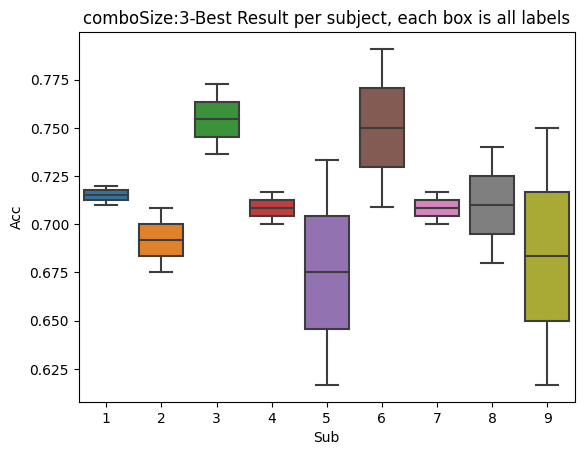

<AxesSubplot: title={'center': 'comboSize:3-Best Result per label, each box is all subjects'}, xlabel='Label', ylabel='Acc'>

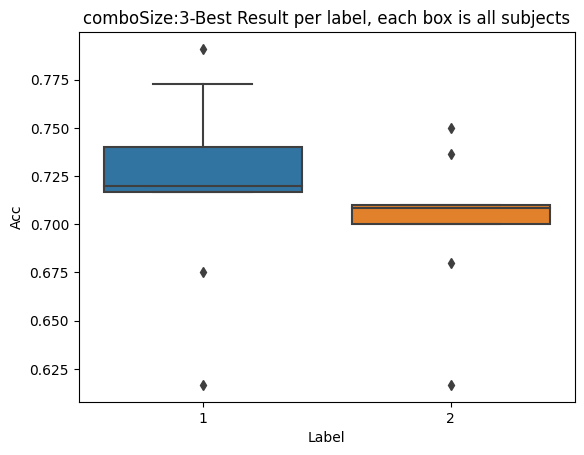

In [237]:
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=combinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels)
    table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
   
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveTop:
    topDF.to_csv(f"topFeaturesResults/topPerSubj-para-{paraName}-cmb-{cmbSize}")
plt.figure()
sns.boxplot(topDF, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(topDF, y = "Acc", x="Label") # , 
   

[0 1]
2
2
0.575
julia
(10, 765)
(765,)
160
765

(9, 7)


<Figure size 640x480 with 0 Axes>

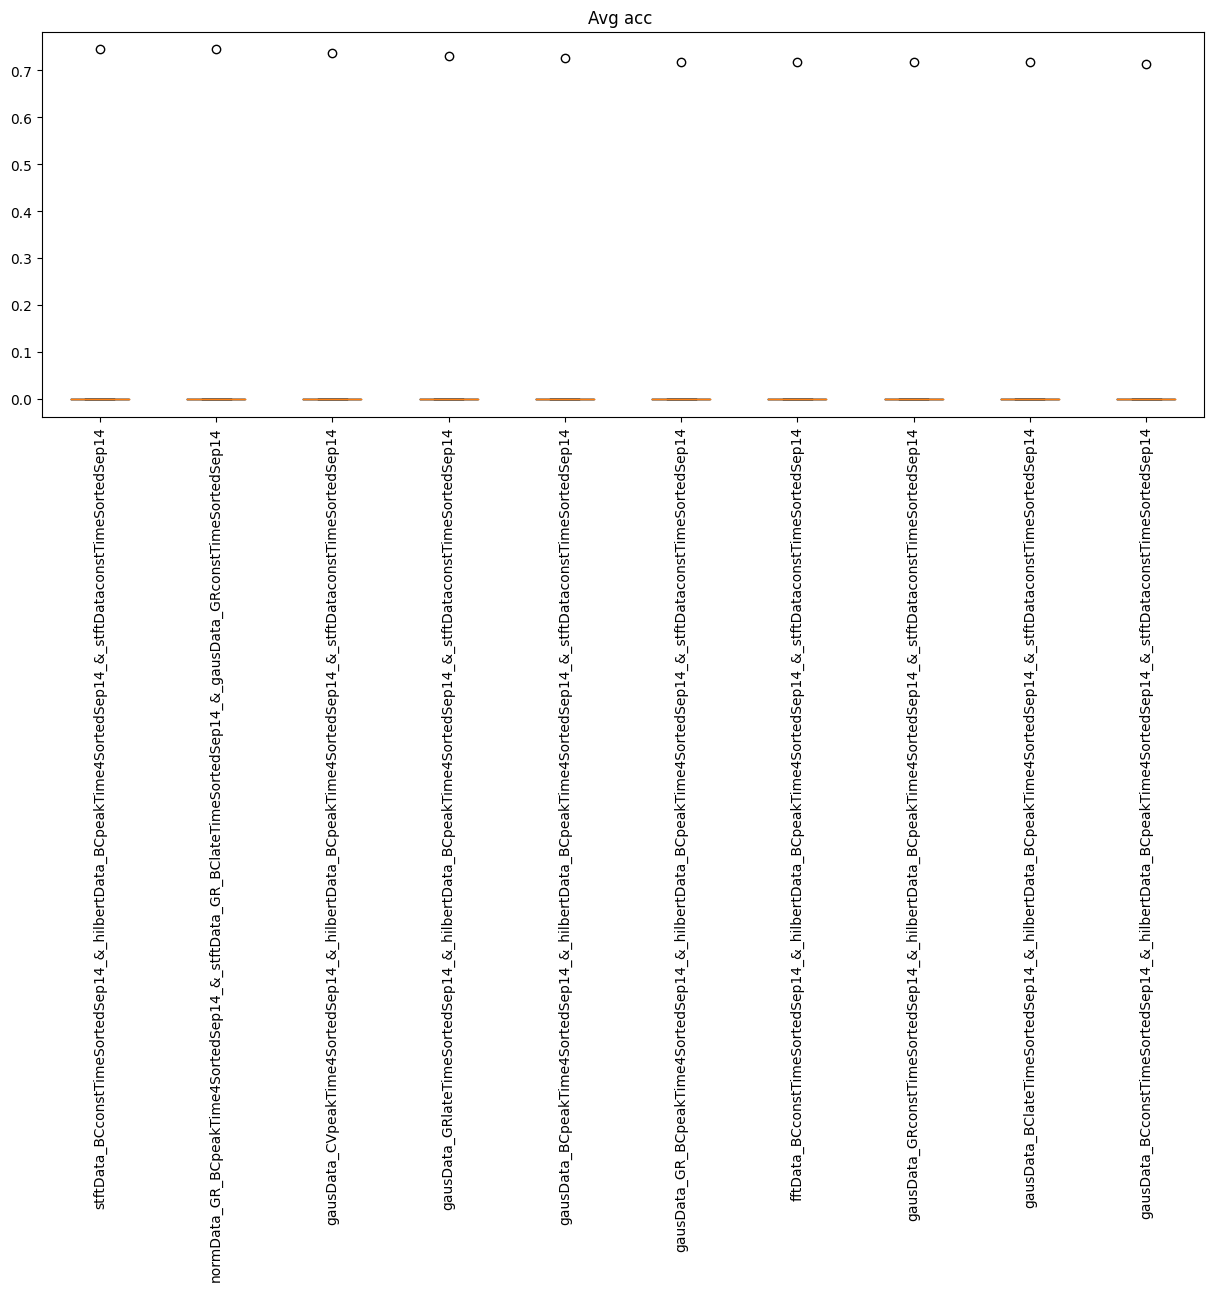

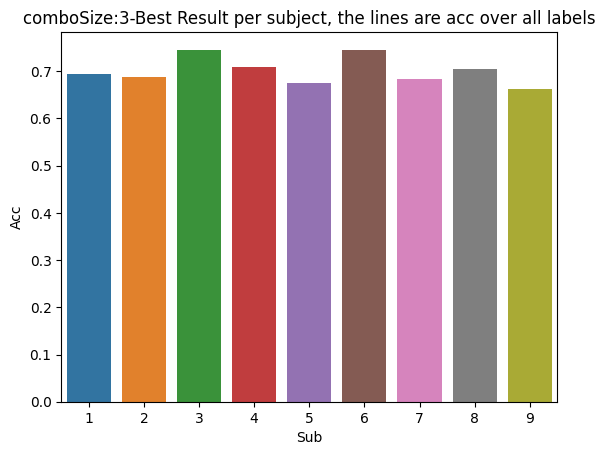

In [238]:
# Average accurracy of all labels
allResults = []
import matplotlib.pyplot as plt

subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
    combinationResultSep=combinationResultSep,
    allCombinations=allCombinations, 
    featCombos=featCombos,
    label=nrOfLabels,
    nrOfCombination=nrOfCombination,
    labels=labels)
table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
newTopTen = []
for feat in topThreeAllSubjects[1:]:
    newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
newTopTen = np.array(newTopTen)
allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
plt.figure()
worstCombos = plotTop(topPerFeature, featCombos, label)


testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
plt.figure()
sns.barplot(topDF, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, the lines are acc over all labels")
plt.show()
# plt.title(f"comboSize:{cmbSize}-Best Result per label,  the lines are acc over all labels")
# sns.barplot(topDF, y = "Acc", x="Feat") # , 
   

In [239]:
print(list(worstCombos.keys()))
np.save(f"worstFeatures/worstFeats{cmbSize}{paraName}", list(worstCombos.keys()))


['normData_GR_BC_CV', 'normData_GR_CV', 'stftData_GR_BC', 'gausData_GR_CV', 'hilbertData_CV_BC', 'gausData_BC_CV', 'stftData_GR_CV', 'stftData_BC', 'stftData_GR', 'fftData_CV', 'hilbertData_BC', 'fftData', 'normData_GR_CV_BC', 'fftData_CV_BC', 'hilbertData_CV', 'normData_GR_BC', 'hilbertData_BC_CV', 'hilbertData', 'fftData_BC_CV', 'gausData_CV', 'stftData', 'stftData_CV', 'normData']


In [240]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


fftDatapeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14  \
0                                              0.000                                                    
1                                              0.695                                                    
2                                              0.000                                                    
3                                              0.000                                                    
4                                              0.000                                                    
5                                              0.000                                                    
6                                              0.000                                                    
7                                              0.000                                                    
8                                              0.000                                                    
9                                              0.000                                                    

   hilbertDatapeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14  \
0                                              0.000                                                        
1                                              0.565                                                        
2                                              0.000                                                        
3                                              0.000                                                        
4                                              0.000                                                        
5                                              0.000                                                        
6                                              0.000                                                        
7                                              0.000                                                        
8                                              0.000                                                        
9                                              0.000                                                        

   fftData_CVpeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14  \
0                                              0.000                                                       
1                                              0.575                                                       
2                                              0.000                                                       
3                                              0.000                                                       
4                                              0.000                                                       
5                                              0.000                                                       
6                                              0.000                                                       
7                                              0.000                                                       
8                                              0.000                                                       
9                                              0.000                                                       

   hilbertData_CVpeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14  \
0                                              0.000                                                           
1                                              0.515                                                           
2                                              0.000                                                           
3         

In [241]:
for x in timesPerCombo:
    print(x)

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


In [242]:
print("Top ten highest accuracies")

# topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.75 : subject 6, feature:normData_GR_BCpeakTime4SortedSep14_&_stftData_GR_BClateTimeSortedSep14_&_gausData_GRconstTimeSortedSep14, kernelsigmoid, C:2.5
Accuracy 0.75 : subject 3, feature:stftData_BCconstTimeSortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14, kernelsigmoid, C:2.5
Accuracy 0.74 : subject 3, feature:gausData_CVpeakTime4SortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14, kernelsigmoid, C:2.5
Accuracy 0.73 : subject 3, feature:gausData_GRlateTimeSortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14, kernelsigmoid, C:2.5
Accuracy 0.73 : subject 3, feature:gausData_BCpeakTime4SortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14, kernelsigmoid, C:2.5
Accuracy 0.72 : subject 3, feature:stftData_BCconstTimeSortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14, kernellinear, C:2.5
Accuracy 0.72 : subject 3, f

In [243]:
# print("Top ten highest accuracies")
# for subTop in topThreeAllSubjects:
#     subTop.reverse()


In [244]:
# Top results, ordered by subject
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[1:]:
    print("")
    for top in subTop[:-1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
# np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)


Accuracy 0.7 : subject 1, feature:fftDatapeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14, kernellinear, C:2.5

Accuracy 0.69 : subject 2, feature:gausData_BClateTimeSortedSep14_&_gausDatalateTimeSortedSep14_&_stftDatalateTimeSortedSep14, kernelsigmoid, C:2.5

Accuracy 0.75 : subject 3, feature:stftData_BCconstTimeSortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14, kernelsigmoid, C:2.5

Accuracy 0.71 : subject 4, feature:gausData_CVconstTimeSortedSep14_&_normData_GRlateTimeSortedSep14_&_normDatapeakTime4SortedSep14, kernellinear, C:2.5

Accuracy 0.68 : subject 5, feature:fftData_BCpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14_&_gausData_BC_CVlateTimeSortedSep14, kernelsigmoid, C:2.5

Accuracy 0.75 : subject 6, feature:normData_GR_BCpeakTime4SortedSep14_&_stftData_GR_BClateTimeSortedSep14_&_gausData_GRconstTimeSortedSep14, kernelsigmoid, C:2.5

Accuracy 0.68 : subject 7, feature:stftDatalateTimeSortedSep14_

In [245]:
topThreeAllSubjects.sort(reverse=True)

In [246]:
# Top results, ordered by best result

# topThreeAllSubjects.sort()

arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[:-1]:
    print("")
    for top in subTop[:-1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
# print(newArrayOfTopFeatureNames)
# newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
# if saveTopName is not None:
#     np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
#     print("TopFeatureNameArraySaved")
#     print(newArrayOfTopFeatureNames)


Accuracy 0.75 : subject 6, feature:normData_GR_BCpeakTime4SortedSep14_&_stftData_GR_BClateTimeSortedSep14_&_gausData_GRconstTimeSortedSep14, kernelsigmoid, C:2.5

Accuracy 0.75 : subject 3, feature:stftData_BCconstTimeSortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14, kernelsigmoid, C:2.5

Accuracy 0.71 : subject 4, feature:gausData_CVconstTimeSortedSep14_&_normData_GRlateTimeSortedSep14_&_normDatapeakTime4SortedSep14, kernellinear, C:2.5

Accuracy 0.7 : subject 8, feature:gausData_GRpeakTime4SortedSep14_&_fftData_CVpeakTime4SortedSep14_&_fftData_BCpeakTime4SortedSep14, kernellinear, C:2.5

Accuracy 0.7 : subject 1, feature:fftDatapeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14, kernellinear, C:2.5

Accuracy 0.69 : subject 2, feature:gausData_BClateTimeSortedSep14_&_gausDatalateTimeSortedSep14_&_stftDatalateTimeSortedSep14, kernelsigmoid, C:2.5

Accuracy 0.68 : subject 7, feature:stftDatalateTimeSortedSep14_&_ff

In [247]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.54476471 0.56401367 0.64055398 0.59607747 0.57698568
 0.62059659 0.56722005 0.59357422 0.57402344]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

Max average accuracy 0.7454545454545454


In [248]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combAverage
normData_GR_BCpeakTime4SortedSep14_&_stftData_GR_BClateTimeSortedSep14_&_gausData_GRconstTimeSortedSep14
sigmoid
0.7454545454545454

stftData_BCconstTimeSortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14
sigmoid
0.7454545454545454

gausData_CVpeakTime4SortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14
sigmoid
0.7363636363636362

gausData_GRlateTimeSortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14
sigmoid
0.7318181818181818

gausData_BCpeakTime4SortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14
sigmoid
0.7272727272727273



In [249]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
normData_GR_BCpeakTime4SortedSep14_&_stftData_GR_BClateTimeSortedSep14_&_gausData_GRconstTimeSortedSep14
sigmoid
0.08282828282828282

stftData_BCconstTimeSortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14
sigmoid
0.08282828282828282

gausData_CVpeakTime4SortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14
sigmoid
0.0818181818181818

gausData_GRlateTimeSortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14
sigmoid
0.08131313131313131

gausData_BCpeakTime4SortedSep14_&_hilbertData_BCpeakTime4SortedSep14_&_stftDataconstTimeSortedSep14
sigmoid
0.08080808080808081



In [250]:
def getRes2(combinationResult, combinationResultSep, allCombinations, featCombos, label, nrOfCombination, labels): 
    headers = np.arange(nrOfCombination)
    subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
    subjectNrList = []  
    comboAverage = np.zeros([1, nrOfCombination])
    comboTotal = np.zeros([1, nrOfCombination])
    nrOfSubjects = np.zeros(nrOfCombination)
    combResLabel = labels[-1]
    topTen = []
    topCombResTen = []
    topThreeAllSubjects = []
    topCombResThreeAllSubjects = []
    topPerFeature = np.zeros([10, len(featCombos)])
    topCombResPerFeature = np.zeros([10, len(featCombos)])
    allCombinations = np.array(allCombinations)
    lowestTopRes = [0, 0]
    for subNr, (cResult, sepResult) in enumerate(zip(combinationResult, combinationResultSep)):
        topThreeThisSubject = []
        topCombResThreeThisSubject = []
        resArray = np.zeros([nrOfCombination])
        if len(cResult) != 0:
            for res, sres in zip(cResult,sepResult):
                cmbNr = int(res[0])
                if onlySignificant == True:
                    if res[1] < minAcc:
                        continue
                res[1] = sres[label+1]
                combRes = sres[combResLabel]
                comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
                comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
                nrOfSubjects[cmbNr] += 1
                subjectResultArray[subNr, cmbNr] = res[1]
                comboName = allCombinations[cmbNr][0]
                nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
                if res[1] > topPerFeature[subNr, nameIndex]:
                    topPerFeature[subNr, nameIndex] = res[1]
                    topCombResPerFeature[subNr, nameIndex] = combRes
                    
                if len(topTen) < 10 or topTen[0][0] < res[1]:

                    if len(topTen) == 10:
                        topTen.reverse()
                        topTen.pop()
                    if len(topCombResTen) == 10:
                        topTen.reverse()
                        topTen.pop()

                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topTen.append([res[1], subNr, dataF, kernel, cVal])
                    topCombResTen.append([combRes, subNr, dataF, kernel, cVal])
                    topTen.sort()
                    topCombResTen.sort()

                
                if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                    if len(topThreeThisSubject) == 2:
                        topThreeThisSubject.reverse()
                        topThreeThisSubject.pop()
                    if len(topCombResThreeThisSubject) == 2:
                        topCombResThreeThisSubject.reverse()
                        topCombResThreeThisSubject.pop()
                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                    topThreeThisSubject.sort()
                    topCombResThreeThisSubject.append([combRes, subNr, dataF, kernel, cVal])
                    topCombResThreeThisSubject.sort()
                    
        if len(topThreeThisSubject)>0:
            topThreeAllSubjects.append(topThreeThisSubject)
        if len(topCombResThreeThisSubject)>0:
            topCombResThreeAllSubjects.append(topCombResThreeThisSubject)
        
        
        
    # Print the table!
    comboAverage = comboAverage / nrOfSubjects
    pd.set_option("display.max_columns", None)

    # For loop through zip of headers and columns,
    # If column has all values == None, Remove column and header.
    subjectResultArray = np.array(subjectResultArray)
    emptyCols = []
    atleastOneEmpty = False
    for hcol, in zip(headers):
        if all(subjectResultArray[:,hcol] == None):
            atleastOneEmpty = True
            emptyCols.append(hcol)
    if atleastOneEmpty: 
        subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
        headers = np.delete(headers, np.array(emptyCols),0)
        comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
        comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
        nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)
    return subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature


(18, 7)


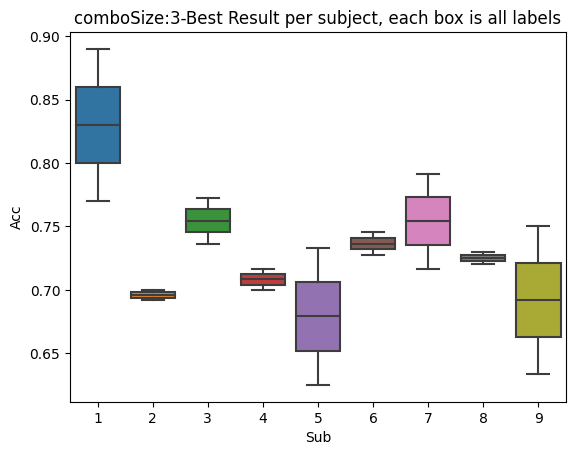

<AxesSubplot: title={'center': 'comboSize:3-Best Result per label, each box is all subjects'}, xlabel='Label', ylabel='Acc'>

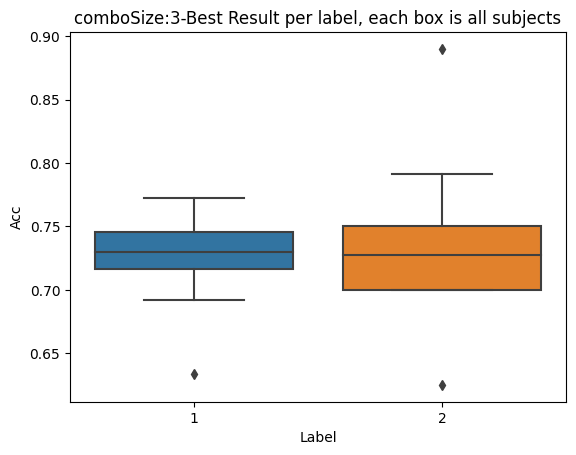

In [251]:
# The results below are taken for best feature and hyperparameters per each feature! Highest classification per feature. 
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes2(combinationResult = combinationResult, 
        combinationResultSep=combinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels)
    table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
    # plotTop(topPerFeature, featCombos, label)
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveTop:
    topDF.to_csv(f"topFeaturesResults/topPerLabel-para-{paraName}-cmb-{cmbSize}")
plt.figure()
sns.boxplot(topDF, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(topDF, y = "Acc", x="Label") # , 
   

In [252]:
# table = pd.DataFrame(np.array(comboTotal), columns=headers)
# display(table)

# maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

# for maxInd2 in np.where(comboTotal == maxVal2)[1]:
#     print(headers[maxInd2])
#     print(nrOfSubjects[maxInd2])
#     print(
#         f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
#     )
#     print(allCombinations[maxInd2][0])
#     print(allCombinations[maxInd2][1])
#     print(f"C: {allCombinations[maxInd2][2]} ")


In [253]:
for names in featCombos:
    print(names)



fftDatapeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14
hilbertDatapeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14
fftData_CVpeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14
hilbertData_CVpeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14
gausDatapeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14
fftData_BCpeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14
hilbertData_BCpeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14
fftData_BC_CVpeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14
hilbertData_BC_CVpeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSep14_&_stftDataconstTimeSortedSep14
gausData_CVpeakTime4SortedSep14_&_normData_GR_CV_BCconstTimeSortedSe